In [6]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple,deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
env=gym.make("CartPole-v1")


In [7]:
class ReplayMemory(object):
    def __init__(self,capacity) -> None:
        self.memory=deque([],maxlen=capacity)
    def push(self,*args):
        self.memory.append(Transition(*args))
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    def __len__(self):
        return len(self.memory)

In [8]:
class DQNnet(nn.Module):
    def __init__(self,n_observations,n_actions):
        super(DQNnet,self).__init__()
        self.layer1=nn.Linear(n_observations,128)
        self.layer2=nn.Linear(128,128)
        self.layer3=nn.Linear(128,n_actions)
    def forward(self,x):
        x=F.relu(self.layer1(x))
        x=F.relu(self.layer2(x))
        return self.layer3(x)

In [11]:

class DQNAgent:
    def __init__(self) :
        self.env=env
        self.batch_size=128
        self.gamma=0.99
        self.eps_start=0.9
        self.eps_end=0.05
        self.eps_decay=1000
        self.tau=0.05
        self.lr=1e-4
        self.n_actions=env.action_space.n
        self.state, self.info=env.reset()
        self.n_observations=len(self.state)
        self.policy_net=DQNnet(self.n_observations,self.n_actions).to(device)
        self.target_net=DQNnet(self.n_observations,self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer=optim.AdamW(self.policy_net.parameters(),lr=self.lr,amsgrad=True)
        self.memory=ReplayMemory(1000)
        self.stepdone=0
    def select_action(self,state):
        sample=random.random()
        eps_threshold=self.eps_end+(self.eps_start-self.eps_end)*math.exp(-1.*self.stepdone/self.eps_decay)
        self.stepdone+=1
        if sample > eps_threshold:
            with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


    episode_durations = []

    def plot_durations(self,show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
            print(next_state_values.size())
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

Complete


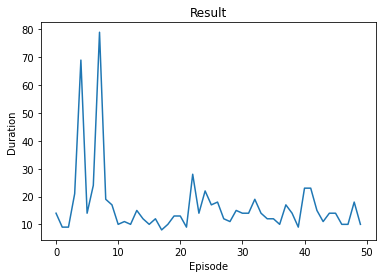

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
Agent=DQNAgent()
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = Agent.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        Agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        Agent.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = Agent.target_net.state_dict()
        policy_net_state_dict = Agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*Agent.tau + target_net_state_dict[key]*(1-Agent.tau)
        Agent.target_net.load_state_dict(target_net_state_dict)

        if done:
            Agent.episode_durations.append(t + 1)
            Agent.plot_durations()
            break

print('Complete')
Agent.plot_durations(show_result=True)
plt.ioff()
plt.show()
